# **AMBIL DATA DARI KAGGLE**

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'real-life-violence-situations-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F176381%2F397693%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T070703Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da54e92aa41717c1e375eeb4c5fc184800c8256d842504a8eb775fda542edf9cfc890603db879fdfeb777e9237513d485442686ae82dfee332435411b40d02f550561c480f7a8f7ca5396a4b365d600c67040ed6359188cd3630f7d99aa6d7bd773bcde77b9600620c22ee136c06bc53d67720be306b203f066431d61aa573af403f493d846b8e4e784590ffc5d2a496d9d63cbec75cb7b3988332b025b15e36234a49b9cc4c6528aa7020216484b6c22310a810ec63e836f570f23c6755053e08bc654c2a0b818ca9a62f4949e03d4e1deb3496bcaa4fe897590ad374b2437f74a009b0dbf9d741a59ae3ae02bea9536075241d4cc96e5b2f367d578decd43a7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


The system cannot find the path specified.


[==================================================] 3847870446 bytes downloaded
Downloaded and uncompressed: real-life-violence-situations-dataset
Data source import complete.


In [1]:
import os
import random
import numpy as np
import cv2
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#set device
device = torch.device('cuda')

In [2]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
DATASET_DIR = "../input/real-life-violence-situations-dataset/Real Life Violence Dataset/"
CLASSES_LIST = ["NonViolence","Violence"]
MAX_FRAMES = 20

In [3]:
torch.cuda.is_available()

True

In [4]:
class VideoDataset(Dataset):
    def __init__ (self, video_paths, labels, transform=None):
        self.viedo_paths = video_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.viedo_paths)
    
    def __getitem__ (self, idx):
        video_path = self.viedo_paths[idx]
        frames = self._extract_frames(video_path)
        label = self.labels[idx]

        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        frames = torch.stack(frames)
        label = torch.tensor(label, dtype=torch.long)

        return frames, label
    
    def _extract_frames(self,video_path):
        frames_list = []
        cap = cv2.VideoCapture(video_path)
        video_frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        skip_frames_window = max(int(video_frames_count / MAX_FRAMES), 1)

        for frame_counter in range(MAX_FRAMES):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame/255.0
            frames_list.append(frame)
        
        cap.release
        return frames_list

In [5]:
def create_dataset():
    features = []
    labels = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        class_dir = os.path.join(DATASET_DIR, class_name)
        video_files = os.listdir(class_dir)

        for file_name in video_files:
            file_path = os.path.join(class_dir, file_name)
            features.append(file_path)
            labels.append(class_index)
    
    return features,labels

In [6]:
#Create the Dataset
video_paths, labels = create_dataset()


In [7]:
#Data Splitting into Train and Test
video_paths_train, video_paths_test, labels_train,labels_test = train_test_split(video_paths, labels, test_size=0.2, 
                                                                                 random_state=42, shuffle=True)

In [8]:
#Define Transforms
transform = transforms.Compose([transforms.ToTensor()])

In [9]:
#Create Datasets
train_dataset = VideoDataset(video_paths_train, labels_train, transform=transform)
test_dataset = VideoDataset(video_paths_test, labels_test, transform=transform)

In [10]:
#Create data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)

In [11]:
class MobiLSTM(nn.Module):
    def __init__(self, num_classes):
        super(MobiLSTM, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True).features
        self.lstm = nn.LSTM(input_size=5120, hidden_size=32, num_layers=2, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()
        x = x.view(batch_size * seq_length, c, h, w)
        x = self.mobilenet(x)
        x = x.view(batch_size, seq_length, -1)
        x, _ =self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.fc5(x)

        return x


In [12]:
num_classes = len(CLASSES_LIST)
model = MobiLSTM(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def train(model, train_loader, criterion, optimizer, device, num_epochs=50):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device).float(), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100. * correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")



In [14]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
        
        test_loss = running_loss / len(test_loader.dataset)
        test_acc = 100. * correct / total

        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
        
        return all_labels, all_preds


In [15]:
for i in range(len(train_dataset)):
    sample, label = train_dataset[i]
    print(f"Sample {i}: {sample.size()}, Label: {label}")
    if i>=10:
        break

Sample 0: torch.Size([20, 3, 64, 64]), Label: 0
Sample 1: torch.Size([20, 3, 64, 64]), Label: 0
Sample 2: torch.Size([20, 3, 64, 64]), Label: 0
Sample 3: torch.Size([20, 3, 64, 64]), Label: 0
Sample 4: torch.Size([20, 3, 64, 64]), Label: 0
Sample 5: torch.Size([20, 3, 64, 64]), Label: 1
Sample 6: torch.Size([20, 3, 64, 64]), Label: 1
Sample 7: torch.Size([20, 3, 64, 64]), Label: 0
Sample 8: torch.Size([20, 3, 64, 64]), Label: 1
Sample 9: torch.Size([20, 3, 64, 64]), Label: 1
Sample 10: torch.Size([20, 3, 64, 64]), Label: 0


In [16]:
# Train the model
train(model, train_loader, criterion, optimizer, device, num_epochs=50)

Epoch [1/50], Loss: 0.6980, Accuracy: 53.12%
Epoch [2/50], Loss: 0.7030, Accuracy: 50.50%


KeyboardInterrupt: 

In [36]:
# Evaluate the model
all_labels, all_preds = evaluate(model, test_loader, criterion, device)

Test Loss: 1.2450, Test Accuracy: 21.43%


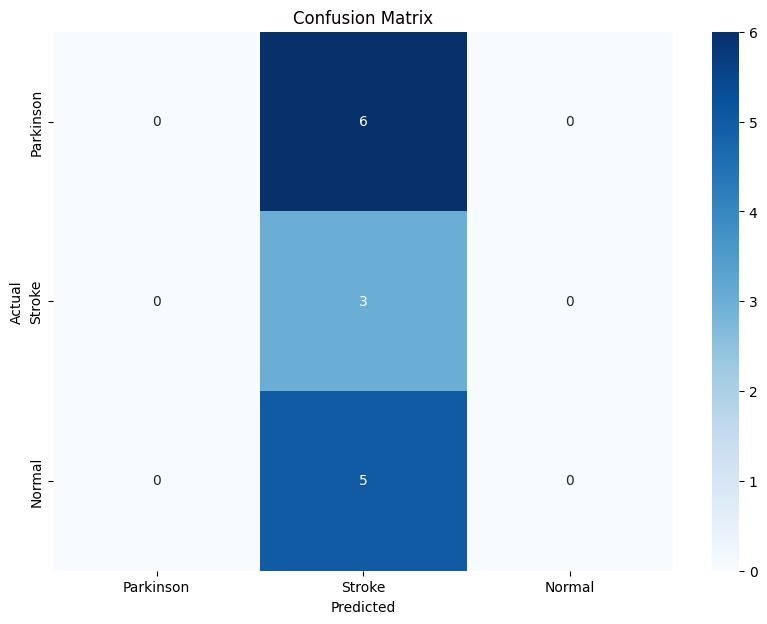

In [37]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()